In [1]:
cd ../TileEM/

/srv/data/home/jlee782/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from paper_visualizations import * 
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
# df = pd.read_csv("all_info.csv",index_col=0)
df_object_batch = pd.read_csv("all_object_batch_info.csv",index_col=0)
df_worker = pd.read_csv("all_worker_response_info.csv",index_col=0)
df_object = pd.read_csv("all_object_info.csv",index_col=0)
df_tile = pd.read_csv("all_tile_info.csv",index_col=0)
df_worker_tile = pd.read_csv("all_worker_tile_info.csv",index_col=0)
df_tile["gt overlap norm tarea"]=df_tile["gt overlap area"]/df_tile["tile area"]
df = df_worker.merge(df_tile)

# Tile overlap distribution analysis

In [4]:
def plot_tile_overlap_distribution(batch,objid,small_tiles=True):
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    avrg_tarea = df_tile_subset["tile area"].mean()
    if small_tiles: df_tile_subset = df_tile_subset[df_tile_subset["tile area"]<avrg_tarea]
    ydata  = df_tile_subset["tile area"]-df_tile_subset["gt overlap area"]
    xdata  = df_tile_subset["gt overlap area"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title("{}; obj{}".format(batch,objid))
    if small_tiles: plt.title("{}; obj{} [small tiles only]".format(batch,objid))
    plt.scatter(xdata,ydata,marker='.',label="Tile")
    partial_frac = len(np.where((xdata!=0)&(ydata!=0))[0])/float(len(ydata))*100
    plt.text(0.87, 0.75,"Partial:{:.2f}%".format(partial_frac),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    plt.text(0.85, 0.70,"Area Cutoff:{:.2f}".format(avrg_tarea),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    plt.text(0.87, 0.65,"Total Tiles:{}".format(len(ydata)),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    x = np.linspace(0,xdata.max())
    def f(x,alpha=1.):
        return alpha*x
    plt.plot(x,f(x),'--',color='red',label="y=x")
    #plt.plot(x,f(x,0.2),'--',color='green',label="y=0.2x")
    # plt.plot(x,f(x,1.2),'--',color='green',label="y=1.2x")
    plt.legend(loc='upper right')
    plt.xlabel("Intersection area",fontsize=13)
    plt.ylabel("Outside area",fontsize=13)

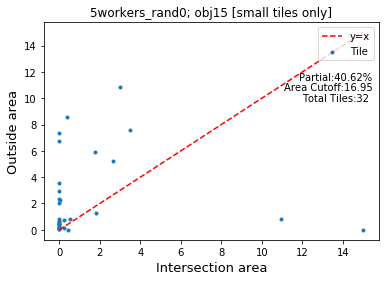

In [5]:
plot_tile_overlap_distribution( '5workers_rand0',15)

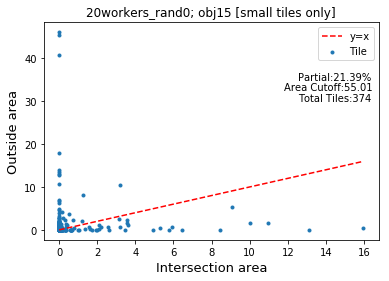

In [6]:
plot_tile_overlap_distribution('20workers_rand0',15)

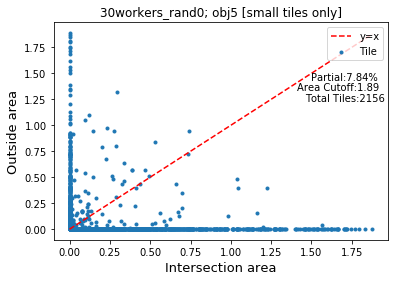

In [7]:
plot_tile_overlap_distribution('30workers_rand0',5)

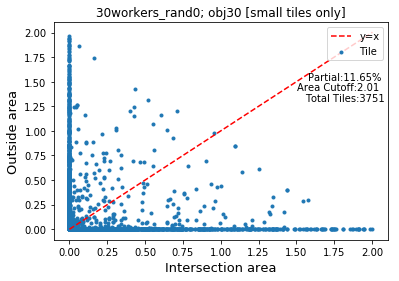

In [8]:
plot_tile_overlap_distribution('30workers_rand0',30)

- [*]compare with where MV does wrong 

# Worker Quality 

we only show this for tiles that are highly voted by many workers 

In [10]:
def plot_overlap_vs_worker_quality_single_column_no_area_split(batch,objid,y_attr):
    df_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = list(set(df_tile_subset["tile id"]))
    for tidx in tile_lst:
        worker_lst = list(set(df_worker_tile_subset["worker id"]))
        yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
        no_workers =[w for w in worker_lst if w not in yes_workers]
        selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(yes_workers))]
        no_selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(no_workers))]
        
        if len(no_selected)>0:
            xdata = np.array(no_selected["gt overlap norm tarea"])
            ydata = no_selected[y_attr]
            plt.plot(xdata,ydata,'.',color='red')
        if len(selected)>0:
            xdata = np.array(selected["gt overlap norm tarea"])
            ydata = selected[y_attr]
            plt.plot(xdata,ydata,'x',color='green')

    plt.title("{}; obj{}".format(batch,objid))
    plt.xlabel("overlap fraction",fontsize=13)
    plt.ylabel(y_attr,fontsize=13)
    plt.xlim(0,1.1)
    plt.legend(['unvoted','voted'],loc="lower right",fontsize=12)

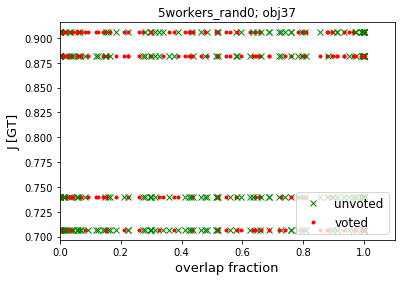

In [ ]:
plot_overlap_vs_worker_quality_single_column_no_area_split('5workers_rand0',37,'J [GT]')

In [43]:
def plot_overlap_vs_worker_quality(batch,objid,y_attr,split=[0.7,0.85],delta=0.03,plot_two_col=False):
    bin2size={0:'small',1:'medium',2:'large'}
    df_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    # if len(df_tile_subset)==0: return
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = np.array(df_tile_subset["tile id"])
    tile_area = np.array(df_tile_subset["tile area"])
    bin_edges = [np.percentile(tile_area,95),np.percentile(tile_area,99)]
    bin_idx = np.digitize(tile_area,bin_edges)
    if plot_two_col: 
        fig,(ax,ax2) = plt.subplots(1, 2, sharex=True)
    for size in list(set(bin_idx)):
        if (not plot_two_col): plt.figure()
        idx = np.where(bin_idx==size)[0]
        if len(idx)!=0:
            for tidx in tile_lst[idx]:
                worker_lst = list(set(df_worker_tile_subset["worker id"]))
                yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
                no_workers =[w for w in worker_lst if w not in yes_workers]
                selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(yes_workers))]
                no_selected = df_subset[(df_subset["tile id"]==tidx)&(df_subset["worker id"].isin(no_workers))]
                if plot_two_col: 
                    
                    xdata1 = np.array(no_selected["gt overlap norm tarea"])
                    ydata1 = np.array(no_selected[y_attr])

                    ax.plot(xdata1, ydata1,'x',color='red')
                    ax2.plot(xdata1, ydata1,'x',color='red')

                    xdata = np.array(selected["gt overlap norm tarea"])
                    ydata = np.array(selected[y_attr])
                    ax.plot(xdata, ydata,'.',color='green')
                    ax2.plot(xdata, ydata,'.',color='green')

                    ymin,ymax= ax.get_ylim()
                    ax.set_ylim(0.5,split[0]) # Definition of bad workers
                    ax2.set_ylim(split[1],1)# Definition of good workers
                    
                    fig.text(0.5, 1,"{}; obj{} [{}]".format(batch,objid,bin2size[size]), ha='center',fontsize=14)
                    fig.text(0.5, 0, 'overlap fraction', ha='center',fontsize=13)
                    fig.text(0.0, 0.5,y_attr, va='center', rotation='vertical',fontsize=13)
                    plt.legend(['unvoted','voted'],bbox_to_anchor=(1.7,1), loc="upper right",fontsize=12)
                else:
                    xdata1 = np.array(no_selected["gt overlap norm tarea"])
                    ydata1 = np.array(no_selected[y_attr])
                    plt.plot(xdata1, ydata1,'x',color='red')

                    xdata = np.array(selected["gt overlap norm tarea"])
                    ydata = np.array(selected[y_attr])
                    plt.plot(xdata, ydata,'.',color='green')
                    plt.xlabel("Overlap Fraction",fontsize=13)
                    plt.ylabel(y_attr,fontsize=13)
                    plt.title("{}; obj{} [{}]".format(batch,objid,bin2size[size]), ha='center',fontsize=14)
                    plt.legend(['unvoted','voted'],bbox_to_anchor=(1.3,1), loc="upper right",fontsize=12)
            plt.xlim(-0.1,1.1)

            plt.tight_layout()

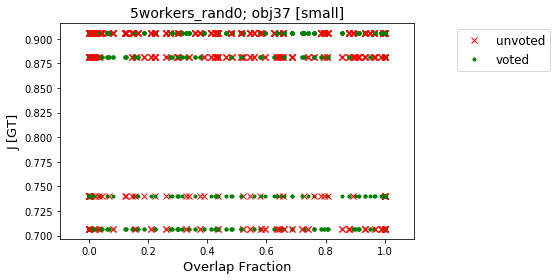

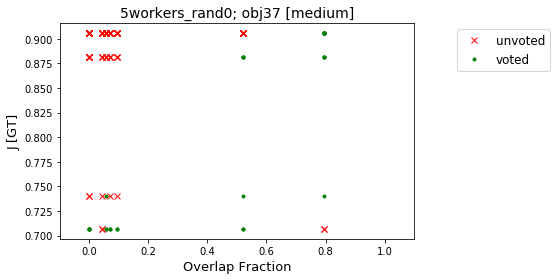

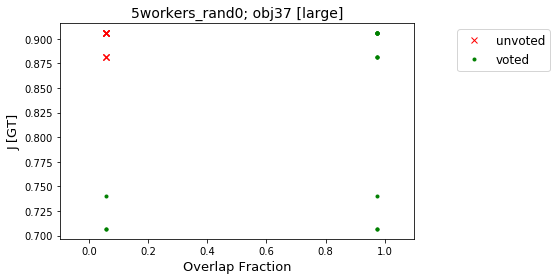

In [42]:
plot_overlap_vs_worker_quality('5workers_rand0',37,'J [GT]')

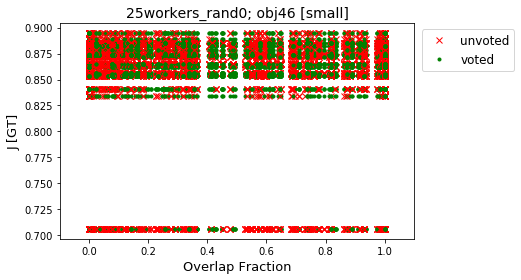

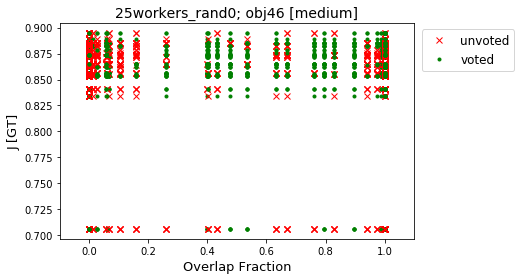

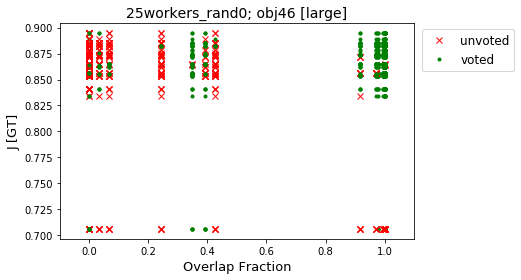

In [44]:
plot_overlap_vs_worker_quality('25workers_rand0',46,'J [GT]')

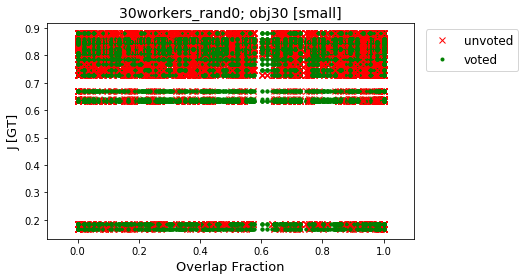

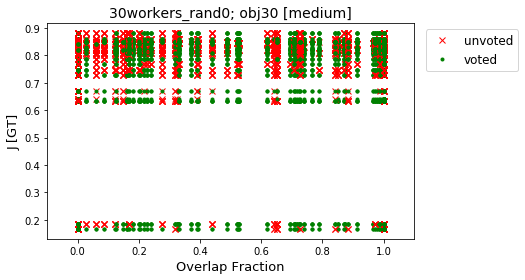

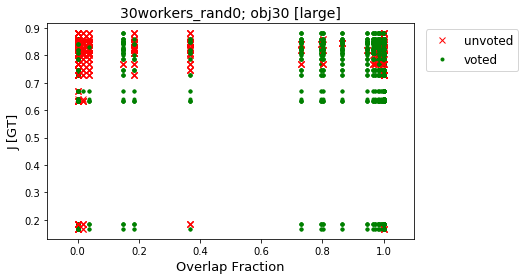

In [45]:
plot_overlap_vs_worker_quality('30workers_rand0',30,'J [GT]')

##### convergence of worker qualities (i.e. picked the same tiles combination) is higher for tiles which are completely inside or outside (i.e. overlap fractions of 0 or 1)

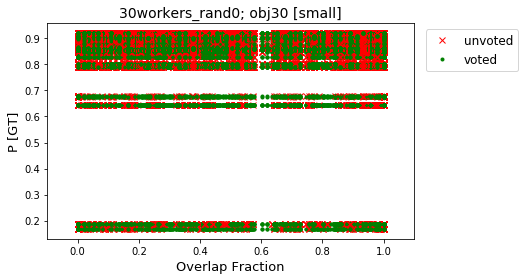

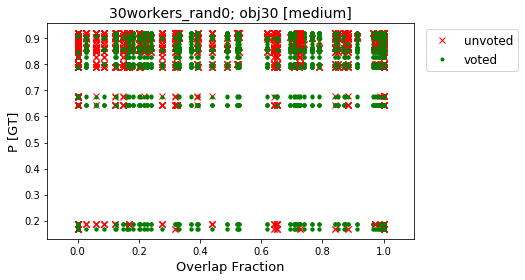

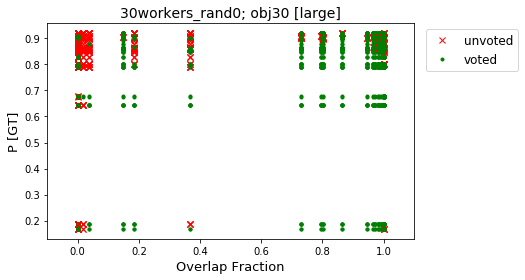

In [46]:
plot_overlap_vs_worker_quality('30workers_rand0',30,'P [GT]')

In [48]:
# plot_overlap_vs_worker_quality('30workers_rand0',30,'R [GT]')

- ~~separate by small tile, medium tile and large tiles~~

- [*] what is the turnover where worker switch from red to green? 

Each vertical line represents a tile. Every horizontal line represents a worker. 

In [32]:
batch = '5workers_rand0'
wid = 196
df_tile["outside area"]=df_tile["tile area"]-df_tile["gt overlap area"]
weighted_qj_tbl = []
for objid in list(set(df_object["objid"])):
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    image_area = float(df_object[df_object["objid"]==objid]["Image area"])
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = list(set(df_worker_tile_subset["tile id"]))
    for wid in list(set(df_worker_tile_subset["worker id"])):#list(set(df_worker["worker id"])):
        voted_tiles = list(df_worker_tile_subset[df_worker_tile_subset["worker id"]==wid]["tile id"])
        if len(voted_tiles)>0:
            non_voted_tiles =[t for t in tile_lst if t not in voted_tiles]
            voted_area_term = df_tile_subset[df_tile_subset["tile id"].isin(voted_tiles)]["gt overlap area"].sum()
            non_voted_area_term = df_tile_subset[df_tile_subset["tile id"].isin(non_voted_tiles)]["outside area"].sum()
            weighted_qj =(non_voted_area_term+voted_area_term)/image_area
            weighted_qj_tbl.append([wid,weighted_qj])

weighted_qj_tbl = pd.DataFrame(weighted_qj_tbl,columns=["worker id","weighted qj"])

df_worker = df_worker.merge(weighted_qj_tbl)

In [33]:
df = df_worker.merge(df_tile)

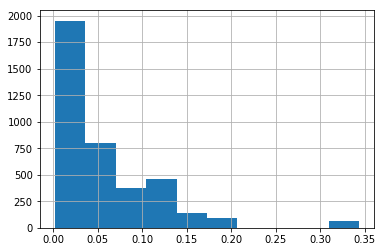

In [34]:
df_worker["weighted qj"].hist()

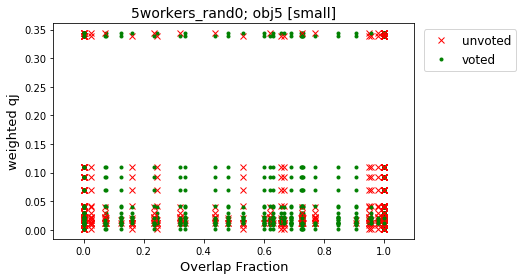

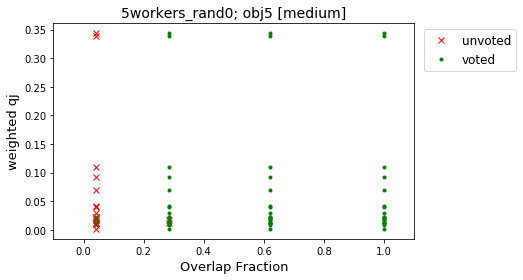

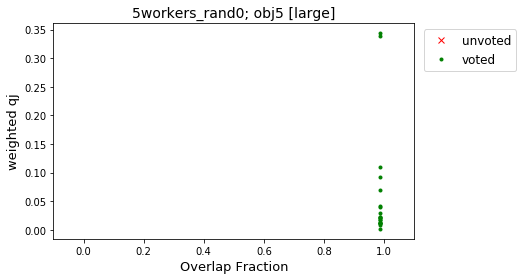

In [49]:
plot_overlap_vs_worker_quality('5workers_rand0',5,"weighted qj")

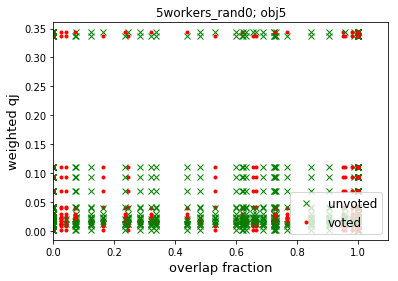

In [52]:
plot_overlap_vs_worker_quality_single_column_no_area_split('5workers_rand0',5,"weighted qj")

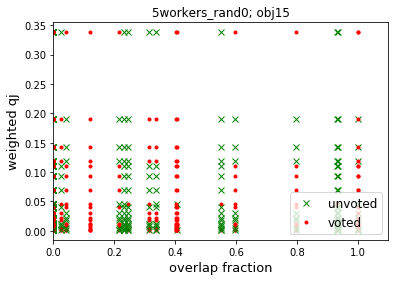

In [54]:
plot_overlap_vs_worker_quality_single_column_no_area_split('5workers_rand0',15,"weighted qj")

# Histogram of mistakes: 
- treat if overlap fraction >0.5 then we pick it, what is the accumlated area of mistake (of the external area) that we would make 
- start off by saying that > 0.5 overlap we pick, so "error area" = outside area of the tile, and <= 0.5 overlap we discard the tile in which case "error area" = intersection area.

In [55]:
def plot_mistake_histogram(batch,objid,small_tiles=True):
    df_tile["tile overlap frac"]=df_tile["gt overlap area"]/df_tile["tile area"]
    df_tile["outside area"]=df_tile["tile area"]-df_tile["gt overlap area"]
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    tile_lst = np.array(list(set(df_tile_subset["tile id"])))
    # tile_area = list(set(df_tile_subset["tile area"]))
    # tile_outside_area = list(set(df_tile_subset["outside area"]))
    mistake_area = []
    mistake_area_overselect = []
    mistake_area_discard = []
    mistake_count =[]
    for tidx in tile_lst:
        df_selected = df_tile_subset[df_tile_subset["tile id"]==tidx]
        if float(df_selected["tile overlap frac"])>=0.5:
            mistake_area.append(float(df_selected["gt overlap area"]))
            mistake_area_overselect.append(float(df_selected["gt overlap area"]))
            mistake_count.append(float(df_selected["tile area"]))
        else: 
            mistake_area.append(float(df_selected["outside area"]))
            mistake_area_discard.append(float(df_selected["outside area"]))
            mistake_count.append(float(df_selected["tile area"]))
    plt.figure()
    plt.title("Selected Mistake Histogram")
    if small_tiles: 
        a = plt.hist([mistake_area_discard,mistake_area_overselect],range=(0,mean(mistake_area)),bins=30)
    else:
        a = plt.hist([mistake_area_discard,mistake_area_overselect],bins=30)
    plt.legend(['discard','overselect'],fontsize=13)
    plt.xlabel("Tile Area",fontsize=13)
    plt.ylabel("Count",fontsize=13)
    plt.figure()
    plt.title("Total Mistake Histogram")
    if small_tiles: 
        a = plt.hist(mistake_area,range=(0,mean(mistake_area)),bins=30)
    else:
        a = plt.hist(mistake_area,bins=30)
    plt.xlabel("Tile Area",fontsize=13)
    plt.ylabel("Count",fontsize=13)

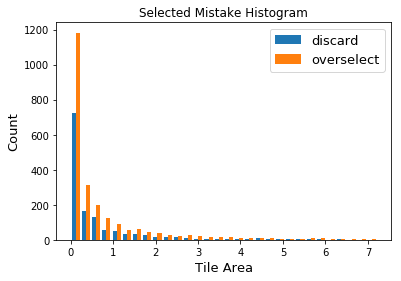

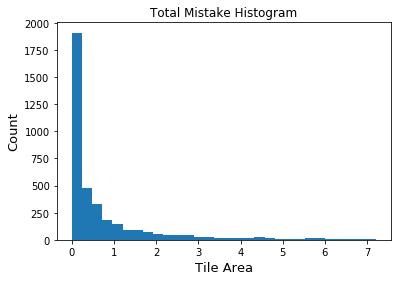

In [56]:
plot_mistake_histogram('30workers_rand0',1)

look at 5 and 10 , less small tiles 

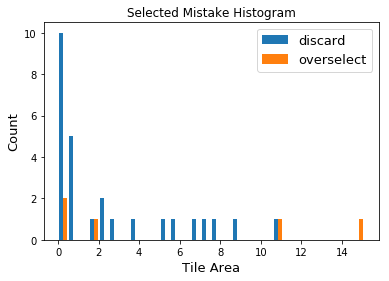

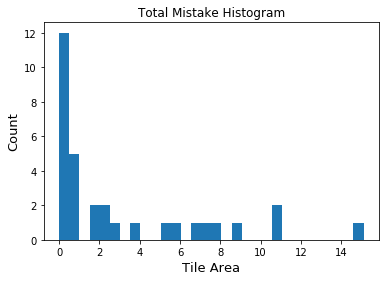

In [54]:
plot_mistake_histogram('5workers_rand0',15)

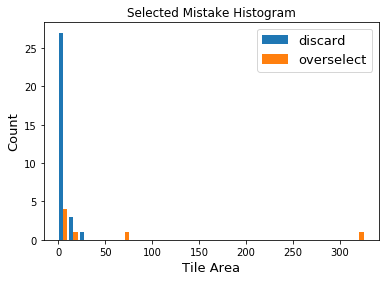

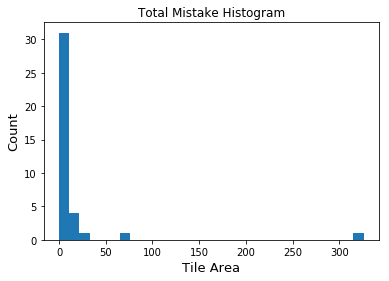

In [57]:
plot_mistake_histogram('5workers_rand0',15,False)

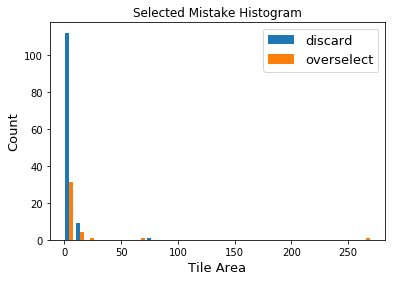

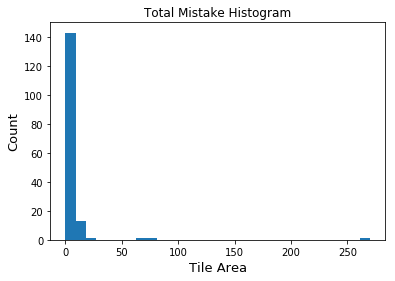

In [59]:
plot_mistake_histogram('10workers_rand0',15,False)